In [3]:
import pickle
import matplotlib.pyplot as plt
import random
import sys
import time
from copy import deepcopy
import numpy as np
import pandas as pd

## Cosine Distance
from scipy.spatial.distance import cosine
import scipy.io

## Keras utilities
import keras
import tensorflow
# from keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, Lambda,  Dense, Flatten,MaxPooling2D,Dropout, UpSampling2D, BatchNormalization
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.engine.input_layer import Input
# from tensorflow.keras.layers import merge
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.regularizers import l2
import numpy.random as rng
from sklearn.utils import shuffle


## Sklearn utilities
#### Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
#### Scores
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#### Feature transformations
import umap
import resnet

import cv2
import os

## Removing some of the useless warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.


In [4]:
## Some useful functions to ease the processings
def save(file,name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'wb')
    else:
        outfile = open(name+'.pickle', 'wb')
    pickle.dump(file, outfile)
    outfile.close
    
def load(name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'rb')
    else:
        outfile = open(name+'.pickle', 'rb')
    file = pickle.load(outfile)
    outfile.close
    return file

def plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    x = list(range(len(acc)))
    plt.plot(x,acc)
    plt.plot(x,val_acc)
    
def cat_to_num(y):
    y1 = []
    for i in range(y.shape[0]):
        a = 0
        for j in range(y.shape[1]):
            a += j*y[i,j]
        y1.append(int(a))
    return y1

def generate_integer():
    
    ints = []
    
    while len(ints)<5:
        r = random.randint(0,63)
        if not(r in ints):
            ints.append(r)
    return ints

In [ ]:
import imageio

In [ ]:
import scipy.io
mat = scipy.io.loadmat('./annotations-mat/001.Black_footed_Albatross/Black_footed_Albatross_0002_2293084168.mat')
img =imageio.imread('./images/001.Black_footed_Albatross/Black_footed_Albatross_0002_2293084168.jpg')

In [ ]:
plt.imshow(img)

In [ ]:
def work(img, mat):
    img1 = deepcopy(img)
#     img1[mat['seg'] == 0] = 255

    x = mat['bbox'][0][0][0][0][0]
    y = mat['bbox'][0][0][1][0][0]
    h = mat['bbox'][0][0][3][0][0] - y
    w = mat['bbox'][0][0][2][0][0] - x

    # img1 = cv2.rectangle(img1,(x,y),(x+w,y+h),(255,0,0),2)
    img1 = img1[ y:y+h,x:x+w,:]

    img1.shape
    x_size = img1.shape[0]
    y_size = img1.shape[1]

    if x_size > y_size:
        add = np.zeros((x_size, int((x_size-y_size)/2), 3))+255
        img1 = np.concatenate([add,img1, add], axis = 1)
    else:
        add = np.zeros((int((y_size-x_size)/2), y_size, 3))+255
        img1 = np.concatenate([add,img1, add], axis = 0)
    img1 = cv2.resize(img1, (128,128))
    img1 = img1/255
    return img1
img1 = work(img, mat)

In [ ]:

plt.imshow(img1)

In [ ]:
path = './images'
path1 = './annotations-mat'

cat_label = 0
images = list(np.zeros(50000))
label = []
count = 0
cat_count = 0
for cat in os.listdir(path):
    if cat[:2] != '._':
        for im_name in os.listdir(path+'/'+cat):
            if im_name[:2] != '._':  
#                 print(path+'/'+cat+'/'+im_name)
                img =imageio.imread(path+'/'+cat+'/'+im_name)
                mat = scipy.io.loadmat(path1+'/'+cat+'/'+im_name[:-4] + '.mat')
                img = work(img, mat)
                label.append(cat_count)
                images[count] = img

                count += 1

                if count%100==0:
                    print(count)

        cat_count += 1

label = np.array(label)
size = label.shape[0]
images = images[:size]
images = np.array(images)


dico={'label' : label,'data' : images}
# save(dico, 'complete_set')

images_meta = images[label < 128]
label_meta = label[label < 128]

images_test = images[label >= 128]
label_test = label[label >= 128]

dico={'label' : label_meta,'data' : images_meta}
save(dico, 'training_set')

dico={'label' : label_test,'data' : images_test}
save(dico, 'test_set')

In [5]:
OT = load('training_set')
OT.keys()
X_meta = OT['data']
Y_meta = OT['label']
# Y_charactere = OT['character']

y_meta = np_utils.to_categorical(Y_meta)

In [6]:
y_meta.shape

(3834, 128)

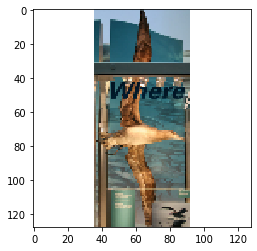

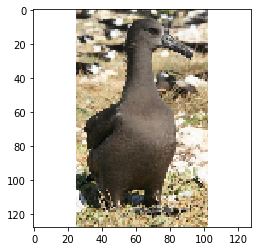

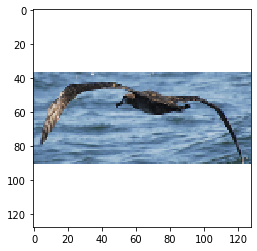

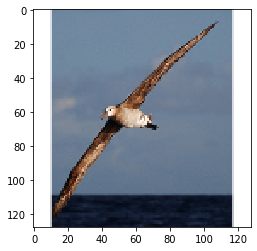

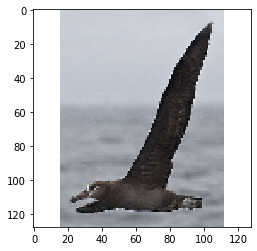

In [7]:
for i in range(5):
    plt.figure(i)
    plt.imshow(X_meta[i])

In [8]:
# X_meta = X_meta[Y_meta <= 5]
# y_meta = y_meta[Y_meta <= 5]
# Y_meta = Y_meta[Y_meta <= 5]

X_train, X_test, y_train, y_test = train_test_split(X_meta, y_meta, test_size=0.2, random_state=42)

In [27]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

base_model = VGG16(weights='imagenet', include_top=False, input_shape = (128,128,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(128, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(128, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
# x = preprocess_input(x)

# for layer in model.layers[:-3]:
#     layer.trainable = False

In [ ]:
model = load('2.VGG with augmentation', 'model')
for layer in model.layers:
    layer.trainable = True
    
# for layer in model.layers[:-8]:
#     layer.trainable = False

In [ ]:
model.summary()

In [55]:
import resnet
build = resnet.ResnetBuilder()
model = build.build_resnet_12((128,128,3),128)

In [56]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_265 (Conv2D)             (None, 64, 64, 64)   9472        input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_239 (BatchN (None, 64, 64, 64)   256         conv2d_265[0][0]                 
__________________________________________________________________________________________________
activation_239 (Activation)     (None, 64, 64, 64)   0           batch_normalization_239[0][0]    
___________________________________________________________________________________________

In [57]:
from cosine_annealing import CosineAnnealingScheduler

callbacks = [
    CosineAnnealingScheduler(T_max=100, eta_max=1e-2, eta_min=1e-4)
]

In [59]:
# aug = ImageDataGenerator(rotation_range=30, zoom_range=0.15,
#                          width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1,
#                          horizontal_flip=True, fill_mode="nearest")
aug = ImageDataGenerator(rotation_range=30, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")

# aug = ImageDataGenerator(rotation_range=30,
#                                width_shift_range=0.2,
#                                height_shift_range=0.2,
#                                shear_range=0.2,
#                                zoom_range=[0.9, 1.25],
#                                horizontal_flip=True,
#                                vertical_flip=True,
#                                fill_mode='reflect',
#                                data_format='channels_last',
#                                brightness_range=[0.5, 1.5])
# import resnet
# build = resnet.ResnetBuilder()
# model = build.build_resnet_18((3,224,224),100)

# model = get_model(100)

# model = resnet2(100)

# model = load('2.resnet2 with augmentation', 'model')

optimizer = SGD(0.1)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,#keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# model.summary()

batch_size = 200
epochs = 500

# history = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
#     validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // batch_size,
#     epochs=epochs)

history = model.fit(X_train, y_train, batch_size=batch_size, epochs = epochs, validation_data=(X_test, y_test), callbacks=callbacks)

# score = model.evaluate(X_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

# save(history, '2.resnet2 with augmentation', 'results')
# save(model, '2.resnet2 with augmentation', 'model')
# plot(history)

Train on 3067 samples, validate on 767 samples
Epoch 1/500
3067/3067 [==============================] - 4s 1ms/sample - loss: 5.0450 - accuracy: 0.1043 - val_loss: 5.3023 - val_accuracy: 0.0456
Epoch 2/500
3067/3067 [==============================] - 2s 739us/sample - loss: 5.0284 - accuracy: 0.1099 - val_loss: 5.2940 - val_accuracy: 0.0443
Epoch 3/500
3067/3067 [==============================] - 2s 743us/sample - loss: 5.0156 - accuracy: 0.1157 - val_loss: 5.2860 - val_accuracy: 0.0430
Epoch 4/500
3067/3067 [==============================] - 2s 744us/sample - loss: 4.9998 - accuracy: 0.1167 - val_loss: 5.2769 - val_accuracy: 0.0404
Epoch 5/500
3067/3067 [==============================] - 2s 739us/sample - loss: 4.9858 - accuracy: 0.1213 - val_loss: 5.2679 - val_accuracy: 0.0430
Epoch 6/500
3067/3067 [==============================] - 2s 757us/sample - loss: 4.9702 - accuracy: 0.1236 - val_loss: 5.2610 - val_accuracy: 0.0482
Epoch 7/500
3067/3067 [==============================] - 2s 7

3067/3067 [==============================] - 2s 771us/sample - loss: 4.4780 - accuracy: 0.2331 - val_loss: 5.0143 - val_accuracy: 0.0639
Epoch 56/500
3067/3067 [==============================] - 2s 790us/sample - loss: 4.4746 - accuracy: 0.2312 - val_loss: 5.0143 - val_accuracy: 0.0639
Epoch 57/500
3067/3067 [==============================] - 3s 826us/sample - loss: 4.4689 - accuracy: 0.2354 - val_loss: 5.0115 - val_accuracy: 0.0639
Epoch 58/500
3067/3067 [==============================] - 2s 780us/sample - loss: 4.4635 - accuracy: 0.2318 - val_loss: 5.0073 - val_accuracy: 0.0613
Epoch 59/500
3067/3067 [==============================] - 2s 766us/sample - loss: 4.4589 - accuracy: 0.2416 - val_loss: 5.0043 - val_accuracy: 0.0665
Epoch 60/500
3067/3067 [==============================] - 2s 785us/sample - loss: 4.4556 - accuracy: 0.2364 - val_loss: 5.0039 - val_accuracy: 0.0652
Epoch 61/500
3067/3067 [==============================] - 2s 760us/sample - loss: 4.4500 - accuracy: 0.2419 - val

3067/3067 [==============================] - 2s 812us/sample - loss: 4.3847 - accuracy: 0.2537 - val_loss: 4.9753 - val_accuracy: 0.0691
Epoch 110/500
3067/3067 [==============================] - 3s 816us/sample - loss: 4.3839 - accuracy: 0.2540 - val_loss: 4.9751 - val_accuracy: 0.0678
Epoch 111/500
3067/3067 [==============================] - 3s 834us/sample - loss: 4.3826 - accuracy: 0.2540 - val_loss: 4.9748 - val_accuracy: 0.0678
Epoch 112/500
3067/3067 [==============================] - 3s 832us/sample - loss: 4.3833 - accuracy: 0.2592 - val_loss: 4.9746 - val_accuracy: 0.0678
Epoch 113/500
3067/3067 [==============================] - 3s 856us/sample - loss: 4.3830 - accuracy: 0.2560 - val_loss: 4.9743 - val_accuracy: 0.0678
Epoch 114/500
3067/3067 [==============================] - 3s 889us/sample - loss: 4.3834 - accuracy: 0.2553 - val_loss: 4.9741 - val_accuracy: 0.0678
Epoch 115/500
3067/3067 [==============================] - 3s 830us/sample - loss: 4.3823 - accuracy: 0.2546

3067/3067 [==============================] - 3s 878us/sample - loss: 4.1986 - accuracy: 0.3052 - val_loss: 4.9032 - val_accuracy: 0.0704
Epoch 164/500
3067/3067 [==============================] - 3s 830us/sample - loss: 4.1934 - accuracy: 0.3120 - val_loss: 4.8944 - val_accuracy: 0.0743
Epoch 165/500
3067/3067 [==============================] - 3s 875us/sample - loss: 4.1834 - accuracy: 0.3189 - val_loss: 4.8899 - val_accuracy: 0.0730
Epoch 166/500
3067/3067 [==============================] - 3s 913us/sample - loss: 4.1764 - accuracy: 0.3150 - val_loss: 4.8861 - val_accuracy: 0.0691
Epoch 167/500
3067/3067 [==============================] - 3s 913us/sample - loss: 4.1690 - accuracy: 0.3130 - val_loss: 4.8877 - val_accuracy: 0.0743
Epoch 168/500
3067/3067 [==============================] - 3s 961us/sample - loss: 4.1584 - accuracy: 0.3176 - val_loss: 4.8843 - val_accuracy: 0.0756
Epoch 169/500
3067/3067 [==============================] - 3s 840us/sample - loss: 4.1507 - accuracy: 0.3241

3067/3067 [==============================] - 3s 821us/sample - loss: 3.6175 - accuracy: 0.4832 - val_loss: 4.7291 - val_accuracy: 0.1004
Epoch 218/500
3067/3067 [==============================] - 2s 779us/sample - loss: 3.6021 - accuracy: 0.4930 - val_loss: 4.7014 - val_accuracy: 0.0991
Epoch 219/500
3067/3067 [==============================] - 2s 815us/sample - loss: 3.5916 - accuracy: 0.4927 - val_loss: 4.6981 - val_accuracy: 0.1004
Epoch 220/500
3067/3067 [==============================] - 2s 808us/sample - loss: 3.5755 - accuracy: 0.5044 - val_loss: 4.7065 - val_accuracy: 0.0965
Epoch 221/500
3067/3067 [==============================] - 3s 815us/sample - loss: 3.5737 - accuracy: 0.4985 - val_loss: 4.7023 - val_accuracy: 0.1043
Epoch 222/500
3067/3067 [==============================] - 2s 798us/sample - loss: 3.5594 - accuracy: 0.5034 - val_loss: 4.6958 - val_accuracy: 0.1004
Epoch 223/500
3067/3067 [==============================] - 2s 807us/sample - loss: 3.5445 - accuracy: 0.5155

3067/3067 [==============================] - 2s 814us/sample - loss: 3.1761 - accuracy: 0.6325 - val_loss: 4.5761 - val_accuracy: 0.1108
Epoch 272/500
3067/3067 [==============================] - 2s 771us/sample - loss: 3.1687 - accuracy: 0.6319 - val_loss: 4.5804 - val_accuracy: 0.1134
Epoch 273/500
3067/3067 [==============================] - 2s 803us/sample - loss: 3.1632 - accuracy: 0.6374 - val_loss: 4.5754 - val_accuracy: 0.1121
Epoch 274/500
3067/3067 [==============================] - 2s 813us/sample - loss: 3.1647 - accuracy: 0.6365 - val_loss: 4.5752 - val_accuracy: 0.1160
Epoch 275/500
3067/3067 [==============================] - 2s 811us/sample - loss: 3.1645 - accuracy: 0.6329 - val_loss: 4.5781 - val_accuracy: 0.1134
Epoch 276/500
3067/3067 [==============================] - 2s 805us/sample - loss: 3.1578 - accuracy: 0.6365 - val_loss: 4.5715 - val_accuracy: 0.1121
Epoch 277/500
3067/3067 [==============================] - 2s 807us/sample - loss: 3.1586 - accuracy: 0.6358

3067/3067 [==============================] - 2s 809us/sample - loss: 3.1199 - accuracy: 0.6495 - val_loss: 4.5650 - val_accuracy: 0.1121
Epoch 326/500
3067/3067 [==============================] - 2s 813us/sample - loss: 3.1199 - accuracy: 0.6440 - val_loss: 4.5657 - val_accuracy: 0.1134
Epoch 327/500
3067/3067 [==============================] - 2s 810us/sample - loss: 3.1149 - accuracy: 0.6466 - val_loss: 4.5635 - val_accuracy: 0.1147
Epoch 328/500
3067/3067 [==============================] - 2s 810us/sample - loss: 3.1131 - accuracy: 0.6488 - val_loss: 4.5618 - val_accuracy: 0.1134
Epoch 329/500
3067/3067 [==============================] - 2s 813us/sample - loss: 3.1129 - accuracy: 0.6534 - val_loss: 4.5625 - val_accuracy: 0.1108
Epoch 330/500
3067/3067 [==============================] - 2s 810us/sample - loss: 3.1086 - accuracy: 0.6492 - val_loss: 4.5585 - val_accuracy: 0.1134
Epoch 331/500
3067/3067 [==============================] - 2s 810us/sample - loss: 3.1057 - accuracy: 0.6550

3067/3067 [==============================] - 3s 815us/sample - loss: 2.7409 - accuracy: 0.7548 - val_loss: 4.5079 - val_accuracy: 0.1147
Epoch 380/500
3067/3067 [==============================] - 2s 809us/sample - loss: 2.7330 - accuracy: 0.7594 - val_loss: 4.5196 - val_accuracy: 0.1252
Epoch 381/500
3067/3067 [==============================] - 2s 805us/sample - loss: 2.7316 - accuracy: 0.7480 - val_loss: 4.5226 - val_accuracy: 0.1147
Epoch 382/500
3067/3067 [==============================] - 2s 815us/sample - loss: 2.7127 - accuracy: 0.7600 - val_loss: 4.4889 - val_accuracy: 0.1252
Epoch 383/500
3067/3067 [==============================] - 2s 811us/sample - loss: 2.6908 - accuracy: 0.7672 - val_loss: 4.4949 - val_accuracy: 0.1213
Epoch 384/500
3067/3067 [==============================] - 3s 816us/sample - loss: 2.6806 - accuracy: 0.7724 - val_loss: 4.5309 - val_accuracy: 0.1199
Epoch 385/500
3067/3067 [==============================] - 2s 811us/sample - loss: 2.6669 - accuracy: 0.7763

3067/3067 [==============================] - 2s 810us/sample - loss: 1.9918 - accuracy: 0.9348 - val_loss: 4.4139 - val_accuracy: 0.1356
Epoch 434/500
3067/3067 [==============================] - 2s 788us/sample - loss: 1.9866 - accuracy: 0.9319 - val_loss: 4.3521 - val_accuracy: 0.1395
Epoch 435/500
3067/3067 [==============================] - 2s 807us/sample - loss: 1.9689 - accuracy: 0.9374 - val_loss: 4.4325 - val_accuracy: 0.1304
Epoch 436/500
3067/3067 [==============================] - 2s 811us/sample - loss: 1.9633 - accuracy: 0.9377 - val_loss: 4.4199 - val_accuracy: 0.1291
Epoch 437/500
3067/3067 [==============================] - 2s 789us/sample - loss: 1.9468 - accuracy: 0.9407 - val_loss: 4.4278 - val_accuracy: 0.1330
Epoch 438/500
3067/3067 [==============================] - 2s 814us/sample - loss: 1.9347 - accuracy: 0.9420 - val_loss: 4.3793 - val_accuracy: 0.1291
Epoch 439/500
3067/3067 [==============================] - 2s 801us/sample - loss: 1.9243 - accuracy: 0.9423

3067/3067 [==============================] - 2s 802us/sample - loss: 1.6770 - accuracy: 0.9772 - val_loss: 4.3263 - val_accuracy: 0.1499
Epoch 488/500
3067/3067 [==============================] - 2s 812us/sample - loss: 1.6765 - accuracy: 0.9778 - val_loss: 4.3244 - val_accuracy: 0.1538
Epoch 489/500
3067/3067 [==============================] - 2s 802us/sample - loss: 1.6744 - accuracy: 0.9762 - val_loss: 4.3249 - val_accuracy: 0.1551
Epoch 490/500
3067/3067 [==============================] - 2s 807us/sample - loss: 1.6743 - accuracy: 0.9762 - val_loss: 4.3261 - val_accuracy: 0.1551
Epoch 491/500
3067/3067 [==============================] - 2s 806us/sample - loss: 1.6772 - accuracy: 0.9778 - val_loss: 4.3250 - val_accuracy: 0.1551
Epoch 492/500
3067/3067 [==============================] - 2s 797us/sample - loss: 1.6811 - accuracy: 0.9762 - val_loss: 4.3258 - val_accuracy: 0.1538
Epoch 493/500
3067/3067 [==============================] - 2s 800us/sample - loss: 1.6756 - accuracy: 0.9759

In [ ]:
save(model, '2.VGG with augmentation', 'model')

In [ ]:
# model_transfert.summary()

from keras.applications import ResNet50
model_transfert = ResNet50(include_top=False, weights='imagenet', input_shape=(84,84,3))

model = Sequential()
model.add(model_transfert)
model.add( MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

In [ ]:
Xt =model.predict(X_train)
Xv =model.predict(X_test)
print(1)
clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial', max_iter = 1000, penalty='l2', n_jobs = 6)
# clf = RandomForestClassifier(n_estimators = 100, n_jobs = 6)
clf.fit(Xt,y_train)
y_pred = clf.predict(Xv)

print(accuracy_score(y_test, y_pred))

In [ ]:
model.summary()

In [ ]:
model_transfert = load('2.resnet2 with augmentation', 'model')

inputs = model_transfert.input
outputs = model_transfert.get_layer('batch_normalization_206').output
outputs = Flatten()(outputs)
model = Model(inputs=inputs,   outputs=outputs)

In [ ]:
Xt = model.predict(X_train)
print(0)
Xv = model.predict(X_test)
print(1)

clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial', max_iter = 1000, penalty='l2')
clf.fit(Xt,y_train)
y_pred = clf.predict(Xv)

print(accuracy_score(y_test, y_pred))

# y_learn = np.concatenate([y_train, y_test1])

In [ ]:
model_transfert = load('2.VGG with augmentation', 'model')

In [ ]:
model_transfert.summary()

In [ ]:
# model_transfert = load('2.resnet2 with augmentation 2', 'model')
#block5_pool dense_1
inputs = model_transfert.input
outputs = model_transfert.get_layer('dense_1').output
# outputs = Flatten()(outputs)
model = Model(inputs=inputs,   outputs=outputs)

In [ ]:
from keras.applications import ResNet50
model_transfert = ResNet50(include_top=False, weights='imagenet', input_shape=(84,84,3))

model = Sequential()
model.add(model_transfert)
model.add( MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

In [ ]:
OT1 = load('test_set')
Y_val = np.array(deepcopy(OT1['label']))
X_val = deepcopy(OT1['data'])
# lab = np.array(deepcopy(OT1['label']))

# alphabet = 3
# X_val = X_val[lab == alphabet]
# Y_val = Y_val[lab == alphabet]

In [ ]:
np.unique(Y_val)

In [ ]:
tab = []
for i in range(np.unique(Y_val).shape[0]):
    tab.append([])

for i in range(len(Y_val)):
    tab[Y_val[i]-Y_val.min()].append(X_val[i])

X = np.array(tab)

In [ ]:
n = 5
k = 5


## A function in order to generate a random array of n distincts values between m and M
def choose_n_classes(n, m, M):
    tab = []
    while len(tab)<n:
        r = random.randint(m,M)
        if not(r in tab):
            tab.append(r)
    tab.sort()
    tab = np.array(tab)
    
    dico = {}
    for i in range(n):
        dico[tab[i]] = i
    
    return tab, dico


## A function to generate data ready for an experiment, tab and dico are here in order to repeat the experiment 
## on the same 5 classes, but with a different number of drawn sample in the class
def build_dataset(X, n,k,value = True, tab = True, dico = True):
    if value == True:
        tab, dico = choose_n_classes(n, 0,X.shape[0]-1)
    
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    
    print(dico)
    
    for elt in tab:
        ind, dico1 = choose_n_classes(k, 0,np.array(X[elt]).shape[0]-1 )
        
        for i in range(np.array(X[elt]).shape[0]):
            if i in ind:
                x_train.append(X[elt][i])
                y_train.append(dico[elt])
            else:
                x_test.append(X[elt][i])
                y_test.append(dico[elt])
    return np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test), tab, dico

In [ ]:
n = 5
k = 5

X_train, X_test, y_train, y_test, tab, dico = build_dataset(X, n, k)#, False, tab, dico)

for i in range(5):
    plt.figure(i)
    plt.imshow(X_train[k*i])

In [ ]:
y_test1 = np.zeros(y_test.shape[0])-1

Xt = model.predict(X_train)
print(0)
Xv = model.predict(X_test)
print(1)

clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial', max_iter = 1000, penalty='l2')
clf.fit(Xt,y_train)
y_pred = clf.predict(Xv)

print(accuracy_score(y_test, y_pred))

y_learn = np.concatenate([y_train, y_test1])

In [ ]:
reducer = umap.UMAP(n_neighbors=7, metric='cosine', n_components=60)

y_test_unsupervised = np.zeros(y_test.shape[0])-1
y_learn = np.concatenate([y_train, y_test_unsupervised])

embedding = reducer.fit(np.concatenate([Xt, Xv], axis=0), y_learn)

Xt1 = embedding.transform(Xt)
Xv1 = embedding.transform(Xv)

In [ ]:
plt.figure(0)
plt.scatter(Xt1[:, 0], Xt1[:, 1], c=y_train, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

plt.figure(1)
plt.scatter(Xv1[:, 0], Xv1[:, 1], c=y_test, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

In [ ]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500)

clf.fit(Xt1,y_train)
y_pseudo = clf.predict(Xv1)

print(accuracy_score(y_test, y_pseudo))

In [ ]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.4)

clf.fit(np.concatenate([Xt, Xv], axis = 0),np.concatenate([y_train, y_pseudo], axis = 0))
y_pred = clf.predict(Xv)

print(accuracy_score(y_test, y_pred))

In [ ]:
scores = []
scores1 = []
scores2 = []
n = 5
k = 5

for i in range(100):
    X_train, X_test, y_train, y_test, tab, dico = build_dataset(X, n, k)
    
    ## First prediction for comparison
    Xt = model.predict(X_train)
    Xv = model.predict(X_test)
    
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.3)
    clf.fit(Xt,y_train)
    y_pred = clf.predict(Xv)
    print(accuracy_score(y_test, y_pred))
    
    a = accuracy_score(y_test, y_pred)
    scores.append(a)
    
    
    y_test_unsupervised = np.zeros(y_test.shape[0])-1
    y_learn = np.concatenate([y_train, y_test_unsupervised])
    
    ## Prediction with umap embedding
    reducer = umap.UMAP(n_neighbors=12, metric='cosine', n_components=20)
    embedding = reducer.fit(np.concatenate([Xt, Xv], axis=0), y_learn)

    Xt1 = embedding.transform(Xt)
    Xv1 = embedding.transform(Xv)
    
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.3)
    clf.fit(Xt1,y_train)
    y_pseudo = clf.predict(Xv1)
    
    print(accuracy_score(y_test, y_pseudo))
    a = accuracy_score(y_test, y_pseudo)
    scores1.append(a)
    
    
    ## Final prediction
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.4)
    clf.fit(np.concatenate([Xt, Xv], axis = 0),np.concatenate([y_train, y_pseudo], axis = 0))

    y_pred = clf.predict(Xv)
    accuracy_score(y_test, y_pred)
    
    a = accuracy_score(y_test, y_pred)
    print(a)
    
    scores2.append(a)
    
print(np.array(scores).mean())
print(np.array(scores1).mean())
print(np.array(scores2).mean())